In [1]:
import torch as th

from environments.environment_tsp import EnviornmentTSP
from networks.basic_network import BasicNetwork
from params import default_params, set_tsp_params
from experiments.actor_critic_experiment import ActorCriticExperiment
from controllers.ac_controller import ActorCriticController
from learners.reinforce_learner import ReinforceLearner
from generators.tsp_generator import TSPGenerator

In [2]:
# Get params
params = default_params()

# Set TSP params
max_nodes_per_graph = 10
embedding_dimension = 4
max_episodes = 1000
episodes_in_batch = 50
instance = 0

params['problem'] = 'tsp'
params['node_dimension'] = 2
params['embedding_dimension'] = embedding_dimension
params['max_nodes_per_graph'] = max_nodes_per_graph
params['max_episode_length'] = max_nodes_per_graph + 1
params['batch_size'] = (max_nodes_per_graph + 1) * episodes_in_batch
params['max_episodes'] = max_episodes
params['max_steps'] = max_episodes * (max_nodes_per_graph + 1) * episodes_in_batch
params['epsilon_start'] = 1.0
params['epsilon_finish'] = 0.005
params['epsilon_anneal_time'] = 0.7 * params['max_steps']
params['entropy_weight'] = 0.1
params['lr'] = 5E-5

# Create network
basic_network = BasicNetwork(max_nodes_per_graph = params['max_nodes_per_graph'], 
                            node_dimension = params['node_dimension'], 
                            embedding_dimension = params['embedding_dimension'])

# Create environment
tsp_generator = TSPGenerator()
# cities = tsp_generator.generate_instance(max_nodes_per_graph)
# cities = th.tensor([[0.0, 0.0], [0.1, 0.1], [0.2, 0.2], [0.3, 0.3], [0.4, 0.4]], dtype=th.float32)
cities = th.load(f"training/tsp/size_{max_nodes_per_graph}/instance_{instance}.pt") 
env = EnviornmentTSP(cities = cities, max_nodes_per_graph = params['max_nodes_per_graph'], node_dimension = params['node_dimension'])

# Create learner 
controller = ActorCriticController(basic_network)
learner = ReinforceLearner(model = basic_network, controller = controller, params = params)

# Create the experiment
experiment = ActorCriticExperiment(params = params, model = basic_network, env = env, learner = learner)


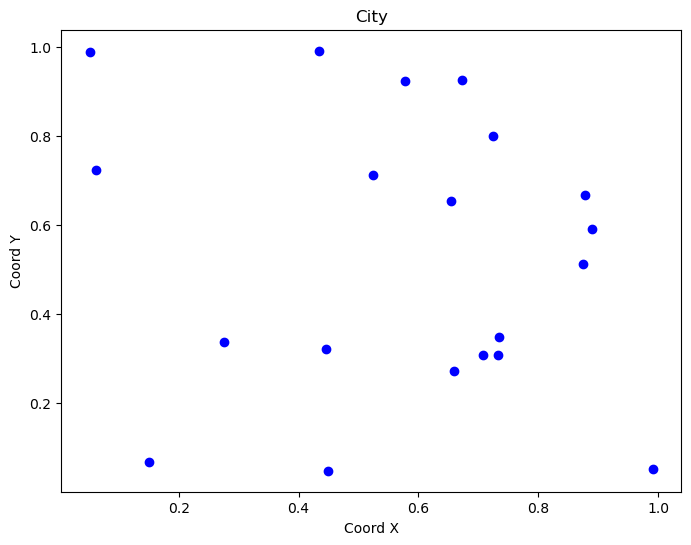

In [3]:
tsp_generator.plot_instance(cities=cities)

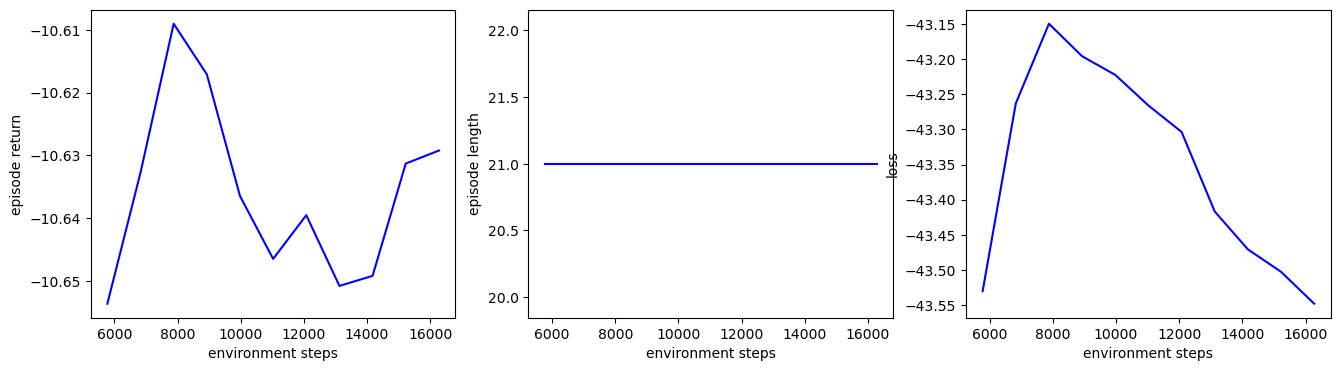

In [ ]:
# Run the experiment
experiment.run()

In [ ]:
experiment.plot_rollout()